In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind

# ===== Your entities =====
from entities_v2 import Experiment, GCaMPData, LimbData, Frame, Clip

In [2]:
DATA_FOLDER = r'Z:\UriMons\Fiber Photometry\GCaMP\adBNST_eEPA_GCaMP8s\Processed_Data\All_pikles'

FRAME_RATE = 30.0          # Hz (behavior frames are 30 fps, we resample neural to this)
MIN_BOUT_S = 1.0           # exclude bouts shorter than this
MAX_BOUT_S = 30.0          # exclude bouts longer than this (None disables)
FIGSIZE = (10, 7)

# Start-aligned heatmap (grooming onset)
START_PRE_S = 5.0          # show -5..0 before start (also baseline)
START_POST_EXTRA_S = 5.0   # show extra after the LONGEST bout

# End-aligned heatmap (bout end at t=0)
END_ALIGN_PRE_S = 10.0     # show -10..0 before end (baseline = -10..-5)
END_ALIGN_POST_S = 10.0    # show 0..+10 after end

# Baseline definitions (THIS is your new z-score)
START_BASELINE = (-5.0, 0.0)     # relative to bout START
END_BASELINE   = (-10.0, -5.0)   # relative to bout END

In [3]:
# - set both None for auto (robust)
# - or set numeric values (e.g. -3, 3) to force a fixed scale
VMIN = None
VMAX = None
USE_SHARED_AUTOSCALE = True
AUTOSCALE_PERCENTILES = (2, 98)

# Window summaries (start-aligned, relative to bout start/end, in seconds)
WINDOWS = [
    ("5sec Pre-Bout Start",     "start", -5,  0),
    ("5sec Post-Bout Start",    "start",  0,  5),
    ("5sec Post-Bout End",      "end",    0,  5),
    ("10sec Post-Bout End",     "end",    5, 10),
    ("20sec Post-Bout End",     "end",    15, 20),
]

# End-aligned windows (relative to bout END, in seconds)
END_WINDOWS = [
    ("End: -10 to -7.5", "end", -10.0, -7.5),
    ("End: -7.5 to -5",  "end",  -7.5, -5.0),
    ("End: -5 to -2.5",  "end",  -5.0, -2.5),
    ("End: -2.5 to 0",   "end",  -2.5,  0.0),
    ("End: 0 to 2.5",    "end",   0.0,  2.5),
    ("End: 2.5 to 5",    "end",   2.5,  5.0),
    ("End: 5 to 7.5",    "end",   5.0,  7.5),
    ("End: 7.5 to 10",   "end",   7.5, 10.0),
]

# End-aligned sorting options
END_SORT_WINDOW_DEFAULT = (0.0, 2.5)  # for sort_by="mean_post" (you can change to (0,5) etc.)

In [4]:
def load_experiments(folder: str):
    exps = []
    for fn in os.listdir(folder):
        if fn.endswith(".pkl"):
            with open(os.path.join(folder, fn), "rb") as f:
                exps.append(pickle.load(f))
    return exps


In [5]:
def group_by_sapap_wt_ko(exps):
    """
    Collapse composite genotype to WT vs KO:
      WT if contains 'SAPAP(WT)'
      KO if contains 'SAPAP(KO)'
    Uses exp.Genotype from your entities.
    """
    groups = {"WT": [], "KO": []}
    for exp in exps:
        geno = getattr(exp, "Genotype", getattr(exp, "genotype", "Unknown"))
        s = str(geno).strip().upper()
        if "SAPAP(WT)" in s:
            groups["WT"].append(exp)
        elif "SAPAP(KO)" in s:
            groups["KO"].append(exp)
        else:
            print(f"Warning: could not classify genotype -> {geno}")

    return {k: v for k, v in groups.items() if len(v)}


In [6]:
def get_bouts_frames(exp):
    """
    RAW grooming bouts only (no smoothing).
    Stored as list of (start_frame, end_frame), frames are 30 fps.
    """
    bouts = exp.Grooming_annotations
    if bouts is None:
        return []
    out = []
    for b in bouts:
        if isinstance(b, (tuple, list)) and len(b) >= 2:
            out.append((int(b[0]), int(b[1])))
        elif isinstance(b, dict):
            s = b.get("Starting frame", b.get("start", b.get("start_frame")))
            e = b.get("Ending frame", b.get("end", b.get("end_frame")))
            if s is not None and e is not None:
                out.append((int(s), int(e)))
        else:
            raise TypeError(f"Unknown bout format: {type(b)} -> {b}")
    return out

In [7]:
_TRACE_CACHE = {}

def get_resampled_trace(exp, target_fr=FRAME_RATE):
    """
    Returns a 1D trace sampled at target_fr with index == 30fps frame number.
    We interpolate exp.GCaMP_data.GCaMP_dF_F onto uniform grid:
      t_grid = 0, 1/target_fr, 2/target_fr, ...
    """
    key = (id(exp), float(target_fr))
    if key in _TRACE_CACHE:
        return _TRACE_CACHE[key]

    gd = exp.GCaMP_data
    if gd is None:
        raise AttributeError("Experiment has no GCaMP_data")

    x = np.asarray(gd.GCaMP_dF_F, dtype=float).squeeze()
    t = np.asarray(gd.time, dtype=float).squeeze()

    if x.ndim != 1 or t.ndim != 1 or len(x) != len(t):
        raise ValueError("GCaMP_dF_F and time must be 1D arrays of equal length")

    if len(t) < 2:
        raise ValueError("GCaMP time array too short")

    t0 = float(t[0])
    t_end = float(t[-1])
    if not np.isfinite(t0) or not np.isfinite(t_end) or t_end <= t0:
        raise ValueError("Bad GCaMP time range")

    # Force start at 0 for frame alignment (your annotations are frame-based at 30 fps)
    # If your time starts at 0 already, this does nothing.
    t = t - t0
    t_end = t_end - t0

    n = int(np.floor(t_end * target_fr)) + 1
    t_grid = np.arange(n, dtype=float) / target_fr

    # Interpolate; outside range -> NaN padding behavior by mask
    x_grid = np.interp(t_grid, t, x, left=np.nan, right=np.nan)

    _TRACE_CACHE[key] = x_grid
    return x_grid


In [8]:
def baseline_z(seg, b0, b1):
    """
    seg: 1D numpy array (may contain NaNs)
    b0, b1: baseline index range [b0:b1] within seg
    returns z-scored seg using baseline mean/std.
    """
    b0 = int(max(0, b0))
    b1 = int(min(len(seg), b1))
    if b1 <= b0:
        return np.full_like(seg, np.nan, dtype=float)

    base = seg[b0:b1]
    mu = np.nanmean(base)
    sd = np.nanstd(base)
    if (not np.isfinite(mu)) or (not np.isfinite(sd)) or sd < 1e-12:
        return np.full_like(seg, np.nan, dtype=float)

    return (seg - mu) / sd

In [9]:
def bout_window_mean_baselinez(trace, s_frame, e_frame, fr, anchor, t0, t1,
                              baseline_anchor, baseline_t0, baseline_t1):
    """
    Compute mean z-score in [t0,t1] relative to anchor ("start" or "end"),
    where z-score is defined using a baseline window [baseline_t0, baseline_t1]
    relative to baseline_anchor ("start" or "end").
    """
    # choose anchor frame for baseline
    base_frame = s_frame if baseline_anchor == "start" else e_frame

    b0 = int(round(base_frame + baseline_t0 * fr))
    b1 = int(round(base_frame + baseline_t1 * fr))
    if b1 <= b0:
        return np.nan
    if b1 <= 0 or b0 >= len(trace):
        return np.nan

    bb0 = max(0, b0)
    bb1 = min(len(trace), b1)
    base_seg = trace[bb0:bb1]
    if base_seg.size < 2:
        return np.nan
    mu = np.nanmean(base_seg)
    sd = np.nanstd(base_seg)
    if (not np.isfinite(sd)) or sd < 1e-12:
        return np.nan

    # choose anchor for measurement
    a_frame = s_frame if anchor == "start" else e_frame
    w0 = int(round(a_frame + t0 * fr))
    w1 = int(round(a_frame + t1 * fr))
    if w1 <= w0:
        return np.nan
    if w1 <= 0 or w0 >= len(trace):
        return np.nan

    ww0 = max(0, w0)
    ww1 = min(len(trace), w1)
    seg = trace[ww0:ww1]
    if seg.size == 0:
        return np.nan

    zseg = (seg - mu) / sd
    return float(np.nanmean(zseg))

def summarize_activity_by_windows_baselinez(exps, fr, windows, min_bout_s,
                                           baseline_anchor, baseline_window):
    """
    windows: list (label, anchor, t0, t1)
    baseline_anchor: "start" or "end"
    baseline_window: (t0, t1) relative to baseline_anchor
    Uses mice as n (average across bouts per mouse).
    """
    min_bout_n = int(round(min_bout_s * fr))
    bucket = {}  # mouse -> label -> list of bout values

    for exp in exps:
        trace = get_resampled_trace(exp, fr)
        mouse = getattr(exp, "Mouse_id", getattr(exp, "MouseID", "Unknown"))

        if mouse not in bucket:
            bucket[mouse] = {w[0]: [] for w in windows}

        for s, e in get_bouts_frames(exp):
            if e <= s:
                continue
            if (e - s) < min_bout_n:
                continue
            if MAX_BOUT_S is not None and (e - s) > int(round(MAX_BOUT_S * fr)):
                continue

            for (label, anchor, t0, t1) in windows:
                val = bout_window_mean_baselinez(
                    trace, s, e, fr, anchor, t0, t1,
                    baseline_anchor=baseline_anchor,
                    baseline_t0=baseline_window[0],
                    baseline_t1=baseline_window[1],
                )
                if np.isfinite(val):
                    bucket[mouse][label].append(val)

    summary = {}
    per_mouse = {}

    for (label, _, _, _) in windows:
        mouse_means = []
        for mouse, d in bucket.items():
            arr = np.asarray(d[label], dtype=float)
            if arr.size == 0:
                continue
            m = np.nanmean(arr)
            if np.isfinite(m):
                mouse_means.append(m)

        mouse_means = np.asarray(mouse_means, dtype=float)
        per_mouse[label] = mouse_means

        n = int(mouse_means.size)
        mean = float(np.nanmean(mouse_means)) if n else np.nan
        sem = float(np.nanstd(mouse_means, ddof=1) / np.sqrt(n)) if n > 1 else np.nan
        summary[label] = {"mean": mean, "sem": sem, "n": n, "unit": "mice"}

    return summary, per_mouse

In [10]:
def bout_length_summary(exps, fr, min_bout_s=0.0, max_bout_s=None):
    min_n = int(round(min_bout_s * fr))
    max_n = int(round(max_bout_s * fr)) if max_bout_s is not None else None

    lengths_s = []
    for exp in exps:
        for s, e in get_bouts_frames(exp):
            if e <= s:
                continue
            dur_n = e - s
            if dur_n < min_n:
                continue
            if max_n is not None and dur_n > max_n:
                continue
            lengths_s.append(dur_n / fr)

    lengths_s = np.asarray(lengths_s, dtype=float)
    n_total = len(lengths_s)
    n_0_2  = int(np.sum((lengths_s >= 0) & (lengths_s < 2)))
    n_2_6  = int(np.sum((lengths_s >= 2) & (lengths_s < 6)))
    n_6_10 = int(np.sum((lengths_s >= 6) & (lengths_s < 10)))
    n_10p  = int(np.sum(lengths_s >= 10))
    return n_total, n_0_2, n_2_6, n_6_10, n_10p

In [11]:
def build_start_aligned_heatmap_matrix(exps, fr, pre_s, post_extra_s, min_bout_s, max_bout_s):
    """
    Align to bout START. Window: [-pre_s, +max_bout_duration + post_extra_s].
    Baseline z-score: -5..0 relative to bout START (the pre window).
    Returns: mat (bouts x time), t (sec), lengths_sorted (sec)
    """
    pre_n = int(round(pre_s * fr))
    extra_n = int(round(post_extra_s * fr))
    min_bout_n = int(round(min_bout_s * fr))
    max_bout_n = int(round(max_bout_s * fr)) if max_bout_s is not None else None

    bouts = []
    max_dur_n = 0

    for exp in exps:
        for s, e in get_bouts_frames(exp):
            if e <= s:
                continue
            dur_n = e - s
            if dur_n < min_bout_n:
                continue
            if max_bout_n is not None and dur_n > max_bout_n:
                continue
            max_dur_n = max(max_dur_n, dur_n)
            bouts.append((exp, s, e, dur_n))

    if not bouts:
        return None, None, None

    n_time = pre_n + max_dur_n + extra_n
    t = (np.arange(n_time) - pre_n) / fr

    rows = []
    lengths_s = []

    for (exp, s, e, dur_n) in bouts:
        trace = get_resampled_trace(exp, fr)
        win_start = s - pre_n
        win_end = s + max_dur_n + extra_n  # exclusive end index

        if win_end <= 0 or win_start >= len(trace):
            continue

        clip_start = max(0, win_start)
        clip_end = min(len(trace), win_end)
        seg = trace[clip_start:clip_end]

        if win_start < 0:
            seg = np.concatenate([np.full(-win_start, np.nan), seg])

        if seg.size < n_time:
            seg = np.concatenate([seg, np.full(n_time - seg.size, np.nan)])
        else:
            seg = seg[:n_time]

        # baseline z using the pre window (0..pre_n corresponds to -pre_s..0)
        seg_z = baseline_z(seg, 0, pre_n)
        rows.append(seg_z)
        lengths_s.append(dur_n / fr)

    if not rows:
        return None, None, None

    mat = np.vstack(rows)
    order = np.argsort(lengths_s)  # short -> long
    lengths_sorted = np.asarray(lengths_s)[order]
    return mat[order], t, lengths_sorted

def build_end_aligned_heatmap_matrix(exps, fr, pre_s, post_s, min_bout_s, max_bout_s,
                                     sort_by="duration", sort_window=END_SORT_WINDOW_DEFAULT):
    """
    Align to bout END (t=0 at end_frame). Window: [-pre_s, +post_s].
    Baseline z-score: -10..-5 relative to bout END (first 5 sec of the window if pre_s=10).
    sort_by:
      - "duration": short -> long
      - "na0":      high -> low value at t=0 (after baseline-z)
      - "mean_post": high -> low mean z in sort_window (seconds relative to t=0)
    Returns: mat, t, durations_s, na0_vals, mean_post_vals
    """
    pre_n = int(round(pre_s * fr))
    post_n = int(round(post_s * fr))
    n_time = pre_n + post_n + 1
    t = (np.arange(n_time) - pre_n) / fr

    min_bout_n = int(round(min_bout_s * fr))
    max_bout_n = int(round(max_bout_s * fr)) if max_bout_s is not None else None

    rows = []
    durations_s = []
    na0_vals = []
    mean_post_vals = []

    # baseline indices inside seg for END_BASELINE = (-10,-5)
    # seg time starts at -pre_s, so baseline window indices:
    # idx(t) = pre_n + t*fr ; but t here is relative to end (t=0 at pre_n)
    b0 = int(round(pre_n + END_BASELINE[0] * fr))  # should be 0 if pre_s=10
    b1 = int(round(pre_n + END_BASELINE[1] * fr))  # should be 5s*fr if pre_s=10

    # sort window indices (relative to t=0)
    w0_s, w1_s = sort_window
    w0_i = int(round(pre_n + w0_s * fr))
    w1_i = int(round(pre_n + w1_s * fr))

    for exp in exps:
        trace = get_resampled_trace(exp, fr)

        for s, e in get_bouts_frames(exp):
            if e <= s:
                continue
            dur_n = e - s
            if dur_n < min_bout_n:
                continue
            if max_bout_n is not None and dur_n > max_bout_n:
                continue

            win_start = e - pre_n
            win_end = e + post_n  # inclusive end
            if win_end < 0 or win_start >= len(trace):
                continue

            clip_start = max(0, win_start)
            clip_end = min(len(trace), win_end + 1)
            seg = trace[clip_start:clip_end]

            if win_start < 0:
                seg = np.concatenate([np.full(-win_start, np.nan), seg])

            if seg.size < n_time:
                seg = np.concatenate([seg, np.full(n_time - seg.size, np.nan)])
            else:
                seg = seg[:n_time]

            # baseline-z for this bout using END_BASELINE (-10..-5 relative to end)
            seg_z = baseline_z(seg, b0, b1)

            rows.append(seg_z)
            durations_s.append(dur_n / fr)

            na0 = seg_z[pre_n] if pre_n < seg_z.size else np.nan
            na0_vals.append(na0)

            ww0 = max(0, min(n_time, w0_i))
            ww1 = max(0, min(n_time, w1_i))
            if ww1 <= ww0:
                mean_post = np.nan
            else:
                mean_post = float(np.nanmean(seg_z[ww0:ww1]))
            mean_post_vals.append(mean_post)

    if not rows:
        return None, None, None, None, None

    mat = np.vstack(rows)
    durations_s = np.asarray(durations_s, dtype=float)
    na0_vals = np.asarray(na0_vals, dtype=float)
    mean_post_vals = np.asarray(mean_post_vals, dtype=float)

    if sort_by == "duration":
        order = np.argsort(durations_s)
    elif sort_by == "na0":
        order = np.argsort(-np.nan_to_num(na0_vals, nan=-np.inf))
    elif sort_by == "mean_post":
        order = np.argsort(-np.nan_to_num(mean_post_vals, nan=-np.inf))
    else:
        raise ValueError("sort_by must be 'duration', 'na0', or 'mean_post'")

    return mat[order], t, durations_s[order], na0_vals[order], mean_post_vals[order]


In [12]:
def compute_shared_vmin_vmax(mats, percentiles=(2, 98)):
    vals = []
    for m in mats:
        if m is None:
            continue
        v = m.ravel()
        v = v[~np.isnan(v)]
        if v.size:
            vals.append(v)
    if not vals:
        return None, None
    allv = np.concatenate(vals)
    lo, hi = np.nanpercentile(allv, percentiles)
    return float(lo), float(hi)

def plot_start_heatmap(mat, t, lengths_s, title, vmin=None, vmax=None, use_step=False):
    plt.figure(figsize=FIGSIZE)
    im = plt.imshow(
        mat, aspect="auto", origin="lower",
        extent=[t[0], t[-1], 0, mat.shape[0]],
        interpolation="nearest", vmin=vmin, vmax=vmax
    )
    plt.axvline(0, color="w", linewidth=2)

    # bout end boundary
    y = np.arange(len(lengths_s)) + 0.5
    x = lengths_s
    if use_step:
        plt.step(x, y, where="mid", color="w", linewidth=2)
    else:
        plt.plot(x, y, color="w", linewidth=2)

    plt.xlabel("Time from grooming onset (s)")
    plt.ylabel("Grooming bouts (short → long)")
    plt.title(title)
    plt.colorbar(im, label="Neural activity (baseline-z)")
    plt.tight_layout()
    plt.show()

def plot_end_heatmap(mat, t, title, vmin=None, vmax=None):
    plt.figure(figsize=FIGSIZE)
    im = plt.imshow(
        mat, aspect="auto", origin="lower",
        extent=[t[0], t[-1], 0, mat.shape[0]],
        interpolation="nearest", vmin=vmin, vmax=vmax
    )
    plt.axvline(0, color="w", linewidth=2)
    plt.xlabel("Time from grooming end (s)")
    plt.ylabel("Grooming bouts")
    plt.title(title)
    plt.colorbar(im, label="Neural activity (baseline-z)")
    plt.tight_layout()
    plt.show()

def _parse_window_label_to_midpoint_seconds(label: str) -> float:
    s = label.replace("End:", "").strip()
    parts = s.split("to")
    a = float(parts[0].strip())
    b = float(parts[1].strip())
    return 0.5 * (a + b)

def plot_end_window_linegraph(end_summ_WT, end_summ_KO, end_windows,
                              title="WT vs KO: END-aligned windowed NA (mean ± SEM)",
                              highlight_window=(0.0, 2.5)):
    labels = [w[0] for w in end_windows]
    x_mid = np.array([_parse_window_label_to_midpoint_seconds(lbl) for lbl in labels], dtype=float)

    wt_mean = np.array([end_summ_WT.get(lbl, {}).get("mean", np.nan) for lbl in labels], dtype=float)
    wt_sem  = np.array([end_summ_WT.get(lbl, {}).get("sem",  np.nan) for lbl in labels], dtype=float)
    ko_mean = np.array([end_summ_KO.get(lbl, {}).get("mean", np.nan) for lbl in labels], dtype=float)
    ko_sem  = np.array([end_summ_KO.get(lbl, {}).get("sem",  np.nan) for lbl in labels], dtype=float)

    wt_n = max([end_summ_WT.get(lbl, {}).get("n", 0) for lbl in labels] + [0])
    ko_n = max([end_summ_KO.get(lbl, {}).get("n", 0) for lbl in labels] + [0])

    plt.figure(figsize=(12, 6))
    plt.axvline(0, color="black", linestyle="--", linewidth=1.5)

    plt.plot(x_mid, wt_mean, marker="o", label=f"WT (n={wt_n})")
    plt.fill_between(x_mid, wt_mean - wt_sem, wt_mean + wt_sem, alpha=0.2)

    plt.plot(x_mid, ko_mean, marker="o", label=f"KO (n={ko_n})", color="red", zorder=3)
    plt.fill_between(x_mid, ko_mean - ko_sem, ko_mean + ko_sem, color="red", alpha=0.2, zorder=1)

    if highlight_window is not None:
        mid = 0.5 * (highlight_window[0] + highlight_window[1])
        idx = int(np.argmin(np.abs(x_mid - mid)))
        if np.isfinite(wt_mean[idx]) and np.isfinite(ko_mean[idx]):
            dy = ko_mean[idx] - wt_mean[idx]
            plt.text(
                x_mid[idx],
                max(wt_mean[idx], ko_mean[idx]),
                f"Δ(KO-WT)={dy:.3f}",
                ha="center",
                va="bottom",
            )

    plt.xlabel("Time relative to bout end (window midpoints, s)")
    plt.ylabel("Neural activity (baseline-z)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [13]:
def print_window_summary(group_label, summary_dict):
    unit = next(iter(summary_dict.values()))["unit"] if summary_dict else "mice"
    print(f"\n{group_label} windowed NA summary ({unit} as n)")
    for k, v in summary_dict.items():
        mean, sem, n = v["mean"], v["sem"], v["n"]
        if not np.isfinite(mean):
            print(f"  {k}: n={n} | mean=nan | sem=nan")
        else:
            print(f"  {k}: n={n} | mean={mean:.3f} | sem={sem:.3f}")

def _p_tag(p):
    if p < 0.05:
        return "  *Significant*"
    if p < 0.1:
        return "  ~Almost significant~"
    return ""

def compare_groups(per_mouse_WT, per_mouse_KO):
    print("\nWT vs KO (Welch t-test)")
    for k in per_mouse_WT:
        a = per_mouse_WT[k]
        b = per_mouse_KO.get(k, np.array([]))
        if len(a) < 2 or len(b) < 2:
            print(f"  {k}: not enough data")
            continue
        t, p = ttest_ind(a, b, equal_var=False)
        print(f"  {k}: WT={np.mean(a):.3f}, KO={np.mean(b):.3f}, p={p:.4g}{_p_tag(p)}")

def compare_within_group(per_mouse, ref_window, group_label):
    print(f"\nWithin-group comparisons ({group_label}) vs {ref_window}")
    ref = per_mouse.get(ref_window, None)
    if ref is None:
        print("  Reference window not found.")
        return

    for k, vals in per_mouse.items():
        if k == ref_window:
            continue
        if len(vals) != len(ref):
            print(f"  {k}: mismatched mice")
            continue
        t, p = ttest_rel(ref, vals)
        print(f"  {k} vs {ref_window}: Δ={np.mean(vals-ref):.3f}, p={p:.4g}{_p_tag(p)}")

Loaded experiments: 15
M329 raw grooming bouts: 62
M338 raw grooming bouts: 55
M344 raw grooming bouts: 70
M352 raw grooming bouts: 76
M354 raw grooming bouts: 98
M365 raw grooming bouts: 52
M406 raw grooming bouts: 90
M407 raw grooming bouts: 153
M416 raw grooming bouts: 59
M420 raw grooming bouts: 44
M501 raw grooming bouts: 45
M508 raw grooming bouts: 78
M511 raw grooming bouts: 55
M546 raw grooming bouts: 56
M561 raw grooming bouts: 48
Collapsed groups: {'WT': 7, 'KO': 8}
WT: n_bouts=265 | 0–2s: 79 | 2–6s: 96 | 6–10s: 49 | ≥10s: 41
KO: n_bouts=361 | 0–2s: 98 | 2–6s: 135 | 6–10s: 49 | ≥10s: 79

WT (START-baseline z) windowed NA summary (mice as n)
  5sec Pre-Bout Start: n=7 | mean=-0.000 | sem=0.000
  5sec Post-Bout Start: n=7 | mean=0.591 | sem=0.113
  5sec Post-Bout End: n=7 | mean=0.631 | sem=0.155
  10sec Post-Bout End: n=7 | mean=0.613 | sem=0.130
  20sec Post-Bout End: n=7 | mean=0.571 | sem=0.129

KO (START-baseline z) windowed NA summary (mice as n)
  5sec Pre-Bout Start: n=

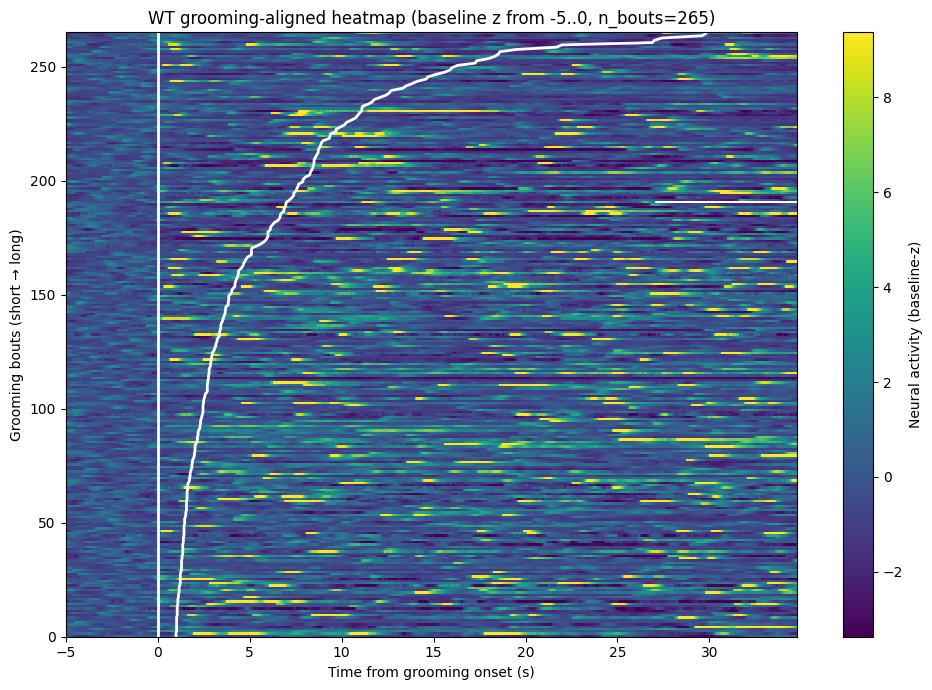

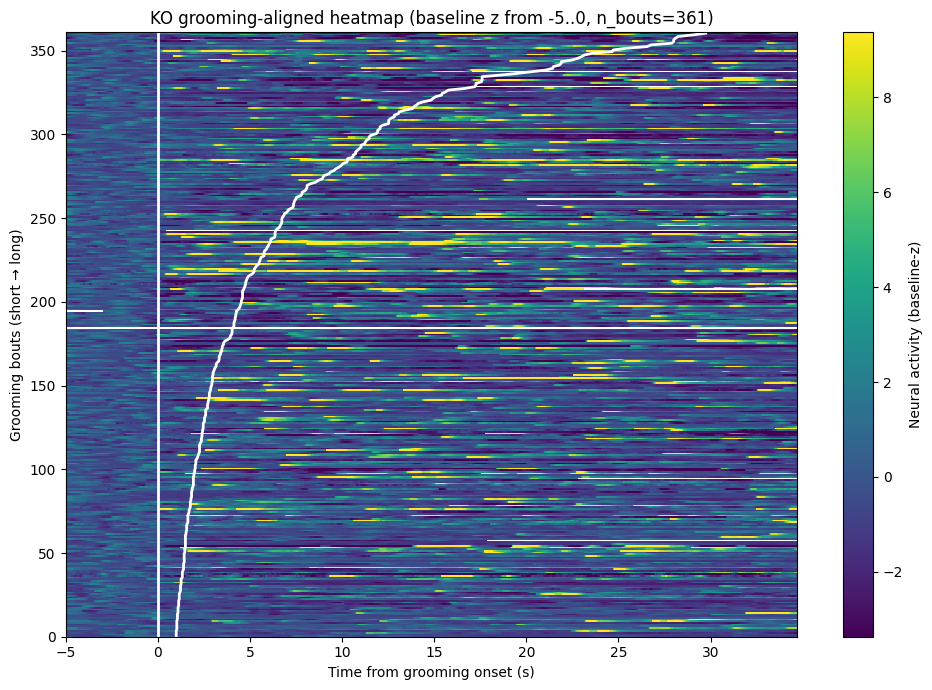


WT (END-baseline z) windowed NA summary (mice as n)
  End: -10 to -7.5: n=7 | mean=0.113 | sem=0.035
  End: -7.5 to -5: n=7 | mean=-0.113 | sem=0.035
  End: -5 to -2.5: n=7 | mean=0.696 | sem=0.356
  End: -2.5 to 0: n=7 | mean=0.445 | sem=0.206
  End: 0 to 2.5: n=7 | mean=0.693 | sem=0.185
  End: 2.5 to 5: n=7 | mean=0.749 | sem=0.253
  End: 5 to 7.5: n=7 | mean=0.770 | sem=0.236
  End: 7.5 to 10: n=7 | mean=0.631 | sem=0.177

KO (END-baseline z) windowed NA summary (mice as n)
  End: -10 to -7.5: n=8 | mean=0.050 | sem=0.036
  End: -7.5 to -5: n=8 | mean=-0.051 | sem=0.035
  End: -5 to -2.5: n=8 | mean=0.500 | sem=0.206
  End: -2.5 to 0: n=8 | mean=0.561 | sem=0.190
  End: 0 to 2.5: n=8 | mean=0.880 | sem=0.272
  End: 2.5 to 5: n=8 | mean=0.630 | sem=0.207
  End: 5 to 7.5: n=8 | mean=0.526 | sem=0.272
  End: 7.5 to 10: n=8 | mean=0.644 | sem=0.280


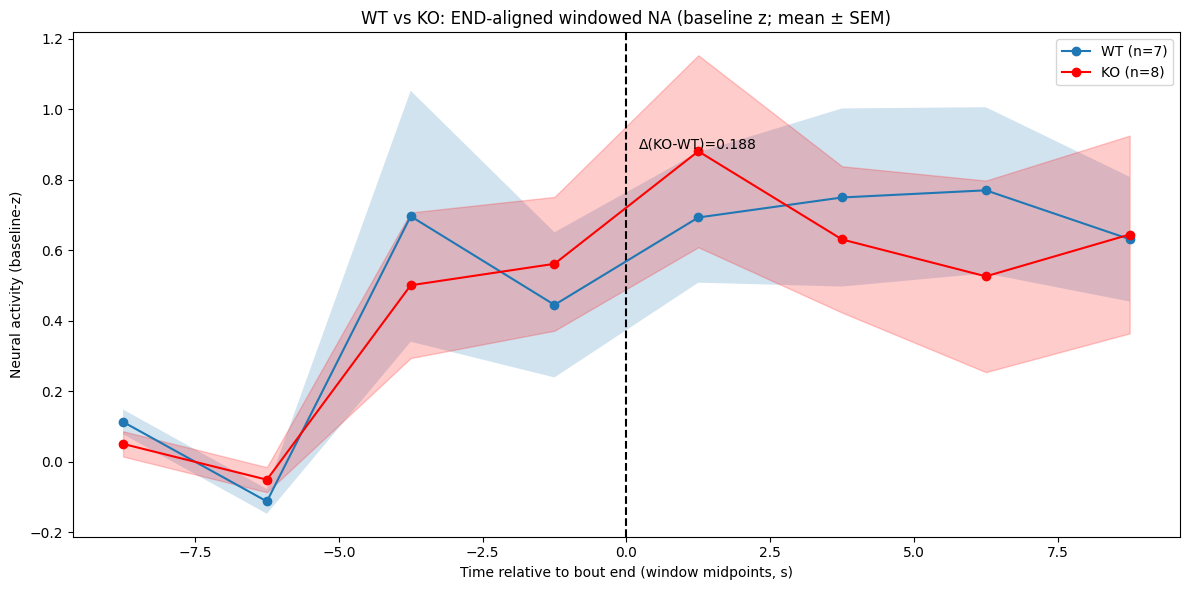


WT vs KO (Welch t-test)
  End: -10 to -7.5: WT=0.113, KO=0.050, p=0.2357
  End: -7.5 to -5: WT=-0.113, KO=-0.051, p=0.239
  End: -5 to -2.5: WT=0.696, KO=0.500, p=0.6447
  End: -2.5 to 0: WT=0.445, KO=0.561, p=0.6844
  End: 0 to 2.5: WT=0.693, KO=0.880, p=0.5788
  End: 2.5 to 5: WT=0.749, KO=0.630, p=0.7219
  End: 5 to 7.5: WT=0.770, KO=0.526, p=0.5094
  End: 7.5 to 10: WT=0.631, KO=0.644, p=0.9687

Within-group comparisons (WT (END-baseline z)) vs End: -2.5 to 0
  End: -10 to -7.5 vs End: -2.5 to 0: Δ=-0.332, p=0.1873
  End: -7.5 to -5 vs End: -2.5 to 0: Δ=-0.558, p=0.02807  *Significant*
  End: -5 to -2.5 vs End: -2.5 to 0: Δ=0.251, p=0.4189
  End: 0 to 2.5 vs End: -2.5 to 0: Δ=0.248, p=0.3393
  End: 2.5 to 5 vs End: -2.5 to 0: Δ=0.305, p=0.2164
  End: 5 to 7.5 vs End: -2.5 to 0: Δ=0.325, p=0.09678  ~Almost significant~
  End: 7.5 to 10 vs End: -2.5 to 0: Δ=0.186, p=0.247

Within-group comparisons (KO (END-baseline z)) vs End: -2.5 to 0
  End: -10 to -7.5 vs End: -2.5 to 0: Δ=-0.511

C:\Users\urimons.WISMAIN\AppData\Local\Temp\ipykernel_2548\255411585.py:147: RuntimeWarning: Mean of empty slice
  mean_post = float(np.nanmean(seg_z[ww0:ww1]))
C:\Users\urimons.WISMAIN\AppData\Local\Temp\ipykernel_2548\841830760.py:13: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(base)
c:\Users\urimons.WISMAIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


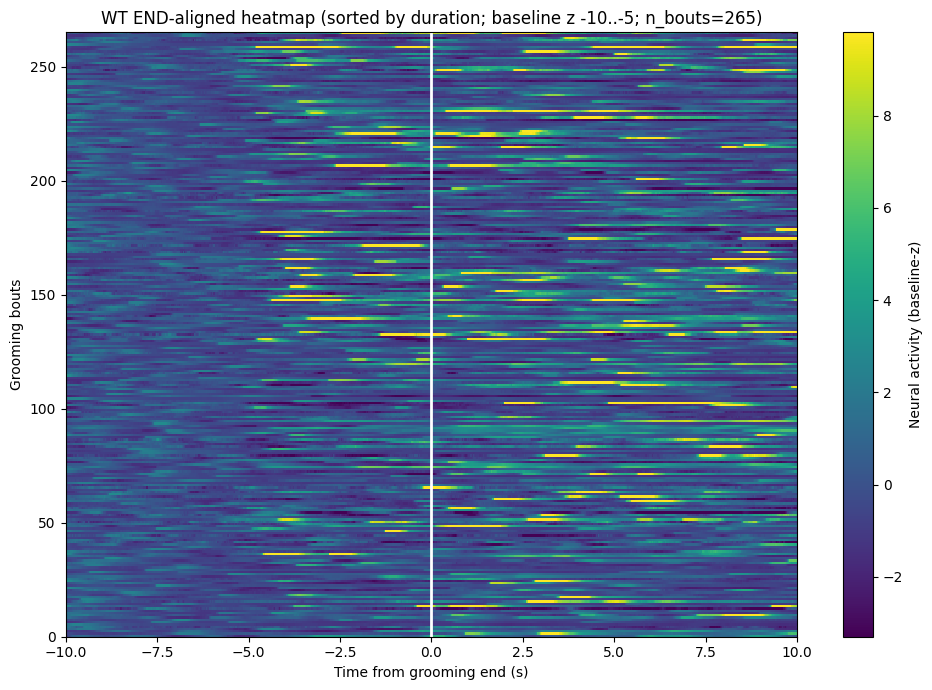

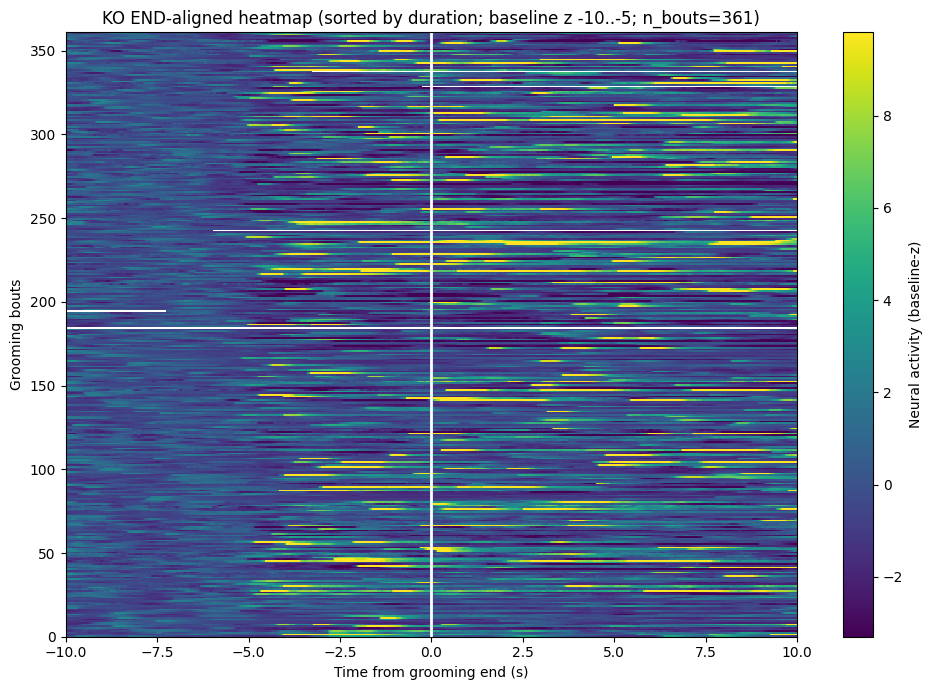

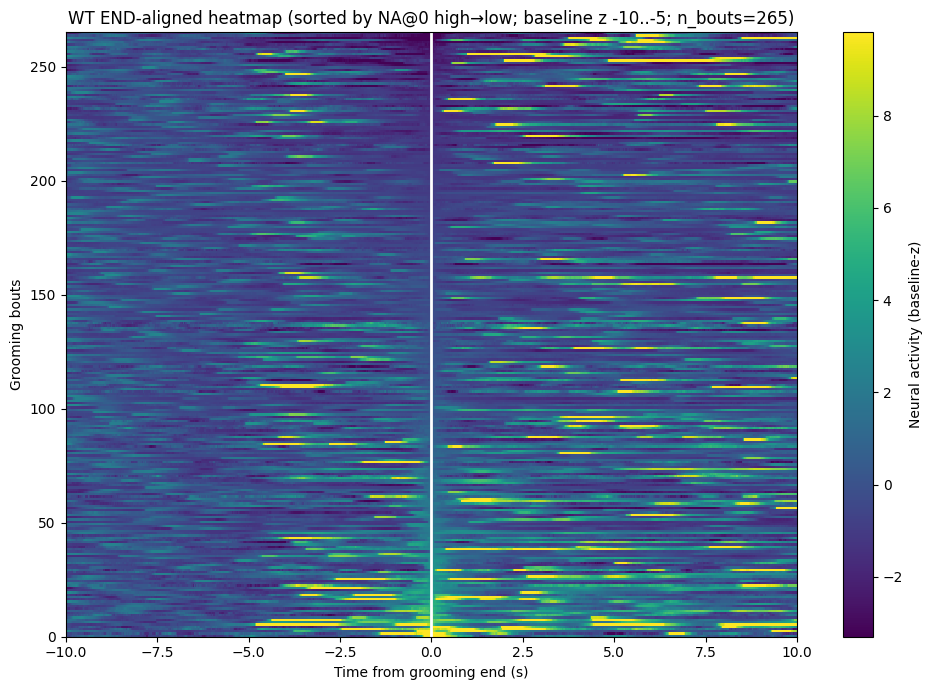

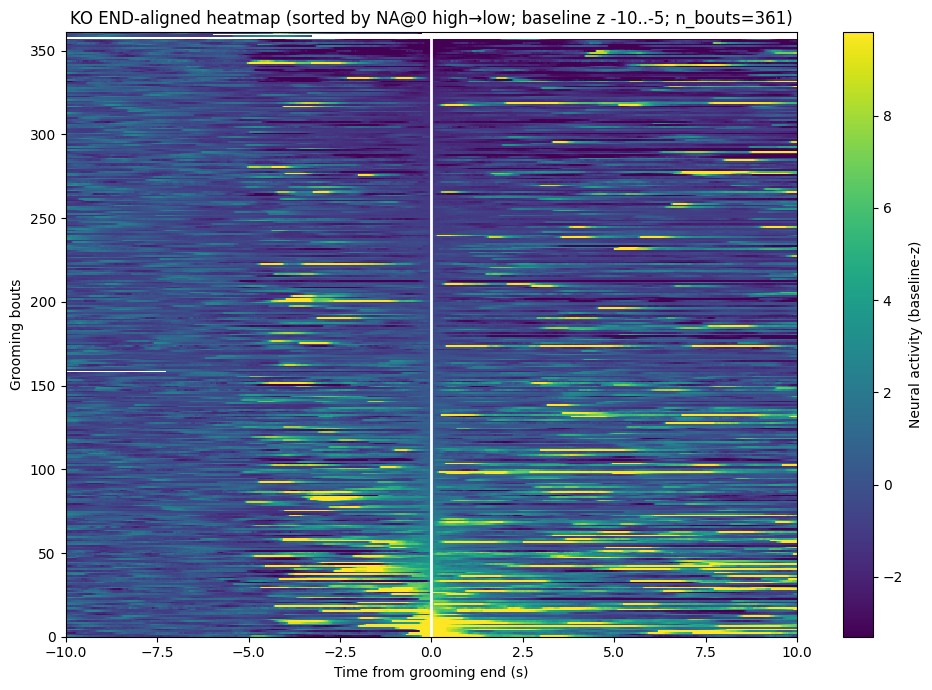

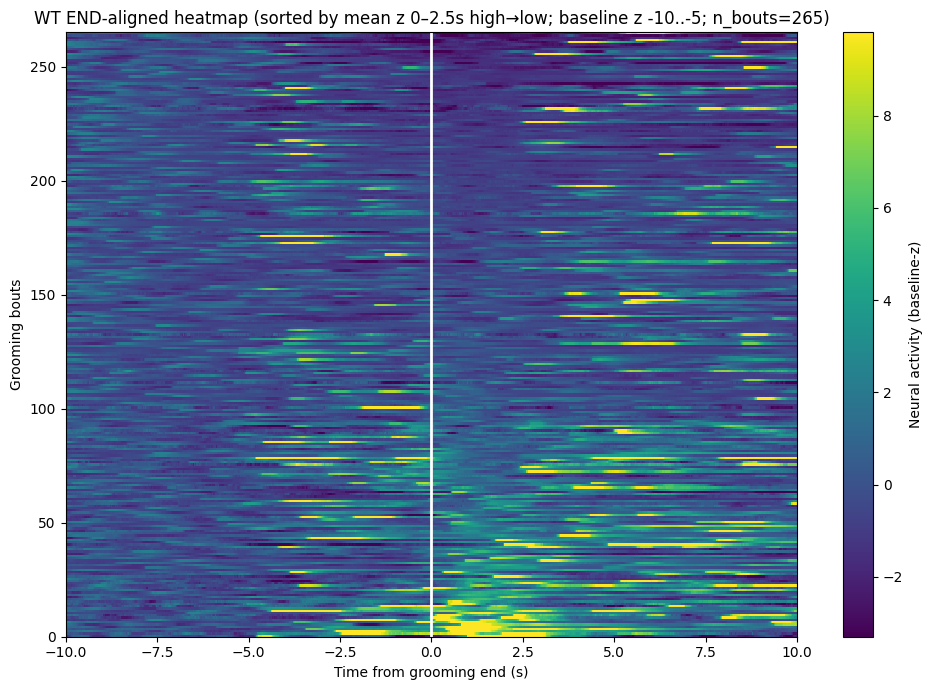

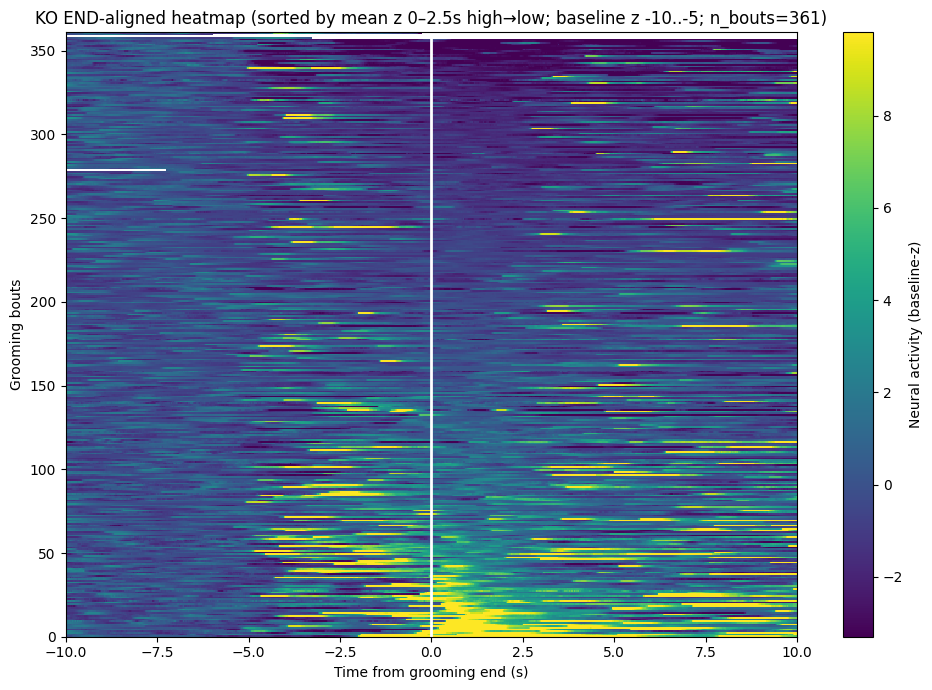

In [14]:
if __name__ == "__main__":

    exps = load_experiments(DATA_FOLDER)
    print(f"Loaded experiments: {len(exps)}")

    # sanity check: raw grooming annotations
    for exp in exps:
        n_bouts = exp.grooming_annotations_count
        print(exp.Mouse_id, "raw grooming bouts:", n_bouts)

    groups = group_by_sapap_wt_ko(exps)
    print("Collapsed groups:", {k: len(v) for k, v in groups.items()})

    # bout length summary
    for label in ["WT", "KO"]:
        if label not in groups:
            continue
        n_total, n_0_2, n_2_6, n_6_10, n_10p = bout_length_summary(
            groups[label], FRAME_RATE, min_bout_s=MIN_BOUT_S, max_bout_s=MAX_BOUT_S
        )
        print(
            f"{label}: n_bouts={n_total} | "
            f"0–2s: {n_0_2} | 2–6s: {n_2_6} | 6–10s: {n_6_10} | ≥10s: {n_10p}"
        )

    # ==========================================================
    # START-ALIGNED WINDOWED NA SUMMARY + STATS
    # baseline = -5..0 relative to START
    # ==========================================================
    if "WT" in groups and "KO" in groups:
        summ_WT, pm_WT = summarize_activity_by_windows_baselinez(
            groups["WT"], FRAME_RATE, WINDOWS, MIN_BOUT_S,
            baseline_anchor="start", baseline_window=START_BASELINE
        )
        summ_KO, pm_KO = summarize_activity_by_windows_baselinez(
            groups["KO"], FRAME_RATE, WINDOWS, MIN_BOUT_S,
            baseline_anchor="start", baseline_window=START_BASELINE
        )

        print_window_summary("WT (START-baseline z)", summ_WT)
        print_window_summary("KO (START-baseline z)", summ_KO)

        compare_groups(pm_WT, pm_KO)

        REF = "5sec Pre-Bout Start"
        compare_within_group(pm_WT, REF, "WT (START-baseline z)")
        compare_within_group(pm_KO, REF, "KO (START-baseline z)")

    # ==========================================================
    # START-ALIGNED HEATMAPS (baseline z with -5..0)
    # ==========================================================
    start_results = {}
    for label in ["WT", "KO"]:
        if label not in groups:
            start_results[label] = (None, None, None)
            continue

        mat, t, lengths_s = build_start_aligned_heatmap_matrix(
            groups[label], FRAME_RATE, START_PRE_S, START_POST_EXTRA_S,
            min_bout_s=MIN_BOUT_S, max_bout_s=MAX_BOUT_S
        )
        start_results[label] = (mat, t, lengths_s)

    # shared vmin/vmax across WT+KO start heatmaps (if requested)
    vmin_use, vmax_use = VMIN, VMAX
    if vmin_use is None and vmax_use is None and USE_SHARED_AUTOSCALE:
        mats_for_scale = []
        for label in ["WT", "KO"]:
            m = start_results.get(label, (None, None, None))[0]
            if m is not None:
                mats_for_scale.append(m)
        vmin_use, vmax_use = compute_shared_vmin_vmax(mats_for_scale, AUTOSCALE_PERCENTILES)

    # Plot start-aligned heatmaps WT then KO
    for label in ["WT", "KO"]:
        mat, t, lengths_s = start_results[label]
        if mat is None:
            print(f"{label}: no valid bouts for START-aligned heatmap.")
            continue

        plot_start_heatmap(
            mat, t, lengths_s,
            title=f"{label} grooming-aligned heatmap (baseline z from -5..0, n_bouts={mat.shape[0]})",
            vmin=vmin_use if VMIN is None else VMIN,
            vmax=vmax_use if VMAX is None else VMAX,
            use_step=False
        )

    # ==========================================================
    # END-ALIGNED WINDOWED NA SUMMARY + STATS
    # baseline = -10..-5 relative to END
    # (these prints/linegraph happen BEFORE end heatmaps)
    # ==========================================================
    if "WT" in groups and "KO" in groups:
        end_summ_WT, end_pm_WT = summarize_activity_by_windows_baselinez(
            groups["WT"], FRAME_RATE, END_WINDOWS, MIN_BOUT_S,
            baseline_anchor="end", baseline_window=END_BASELINE
        )
        end_summ_KO, end_pm_KO = summarize_activity_by_windows_baselinez(
            groups["KO"], FRAME_RATE, END_WINDOWS, MIN_BOUT_S,
            baseline_anchor="end", baseline_window=END_BASELINE
        )

        print_window_summary("WT (END-baseline z)", end_summ_WT)
        print_window_summary("KO (END-baseline z)", end_summ_KO)

        plot_end_window_linegraph(
            end_summ_WT, end_summ_KO, END_WINDOWS,
            title="WT vs KO: END-aligned windowed NA (baseline z; mean ± SEM)",
            highlight_window=(0.0, 2.5),
        )

        compare_groups(end_pm_WT, end_pm_KO)

        END_REF = "End: -2.5 to 0"
        compare_within_group(end_pm_WT, END_REF, "WT (END-baseline z)")
        compare_within_group(end_pm_KO, END_REF, "KO (END-baseline z)")

    # ==========================================================
    # END-ALIGNED HEATMAPS (baseline z from -10..-5)
    #   1) duration (WT → KO)
    #   2) NA@0 (WT → KO)
    #   3) mean_post (WT → KO) using END_SORT_WINDOW_DEFAULT
    # ==========================================================
    end_results = {}
    for label in ["WT", "KO"]:
        if label not in groups:
            end_results[label] = {"dur": None, "na0": None, "mean_post": None, "t": None}
            continue

        mat_dur, t_end, dur_s, na0, mean_post = build_end_aligned_heatmap_matrix(
            groups[label], FRAME_RATE,
            END_ALIGN_PRE_S, END_ALIGN_POST_S,
            min_bout_s=MIN_BOUT_S, max_bout_s=MAX_BOUT_S,
            sort_by="duration"
        )

        mat_na0, t_end2, dur_s2, na0_2, mean_post2 = build_end_aligned_heatmap_matrix(
            groups[label], FRAME_RATE,
            END_ALIGN_PRE_S, END_ALIGN_POST_S,
            min_bout_s=MIN_BOUT_S, max_bout_s=MAX_BOUT_S,
            sort_by="na0"
        )

        mat_mp, t_end3, dur_s3, na0_3, mean_post3 = build_end_aligned_heatmap_matrix(
            groups[label], FRAME_RATE,
            END_ALIGN_PRE_S, END_ALIGN_POST_S,
            min_bout_s=MIN_BOUT_S, max_bout_s=MAX_BOUT_S,
            sort_by="mean_post",
            sort_window=END_SORT_WINDOW_DEFAULT
        )

        end_results[label] = {"dur": mat_dur, "na0": mat_na0, "mean_post": mat_mp, "t": t_end}

    # shared vmin/vmax across all end heatmaps (if requested)
    end_vmin_use, end_vmax_use = VMIN, VMAX
    if end_vmin_use is None and end_vmax_use is None and USE_SHARED_AUTOSCALE:
        mats_for_scale = []
        for label in ["WT", "KO"]:
            for key in ["dur", "na0", "mean_post"]:
                m = end_results[label].get(key, None)
                if m is not None:
                    mats_for_scale.append(m)
        end_vmin_use, end_vmax_use = compute_shared_vmin_vmax(mats_for_scale, AUTOSCALE_PERCENTILES)

    # ---- 1) duration WT then KO
    for label in ["WT", "KO"]:
        mat = end_results[label]["dur"]
        t_end = end_results[label]["t"]
        if mat is None:
            print(f"{label}: no valid bouts for END heatmap (duration).")
            continue
        plot_end_heatmap(
            mat, t_end,
            title=f"{label} END-aligned heatmap (sorted by duration; baseline z -10..-5; n_bouts={mat.shape[0]})",
            vmin=end_vmin_use if VMIN is None else VMIN,
            vmax=end_vmax_use if VMAX is None else VMAX,
        )

    # ---- 2) NA@0 WT then KO
    for label in ["WT", "KO"]:
        mat = end_results[label]["na0"]
        t_end = end_results[label]["t"]
        if mat is None:
            print(f"{label}: no valid bouts for END heatmap (NA@0).")
            continue
        plot_end_heatmap(
            mat, t_end,
            title=f"{label} END-aligned heatmap (sorted by NA@0 high→low; baseline z -10..-5; n_bouts={mat.shape[0]})",
            vmin=end_vmin_use if VMIN is None else VMIN,
            vmax=end_vmax_use if VMAX is None else VMAX,
        )

    # ---- 3) mean_post WT then KO
    w0, w1 = END_SORT_WINDOW_DEFAULT
    for label in ["WT", "KO"]:
        mat = end_results[label]["mean_post"]
        t_end = end_results[label]["t"]
        if mat is None:
            print(f"{label}: no valid bouts for END heatmap (mean_post).")
            continue
        plot_end_heatmap(
            mat, t_end,
            title=(f"{label} END-aligned heatmap "
                   f"(sorted by mean z {w0:g}–{w1:g}s high→low; baseline z -10..-5; n_bouts={mat.shape[0]})"),
            vmin=end_vmin_use if VMIN is None else VMIN,
            vmax=end_vmax_use if VMAX is None else VMAX,
        )